# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
from skimage.metrics import structural_similarity as ssim
import pickle
from common.subsample import MaskFunc

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


# Loading MRI measurement

In [2]:
### Get image from the validation set
filename = '/hdd/multicoil_val/file1000190.h5' # good (scale: 3.2) 140 channels

f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2

slice_ksp = f['kspace'][slicenu]

slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor
slice_image = transform.ifft2(slice_ksp_torchtensor)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image)   # Compute absolute value to get a real image

Kspace shape (number slices, number coils, x, y):  (36, 15, 640, 368)


In [3]:
numit = 25000
LR = 0.005

In [4]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

num_channels = 256
num_layers = 7
strides = [1]*(num_layers-1)
pads = [1]*(num_layers-1)
in_size = [10,5]

parnet = convdecoder(out_size,in_size,output_depth,
                           num_layers,strides,pads,num_channels,skips=False,need_sigmoid=False,bias=True,upsample_mode="nearest").type(dtype)
print(num_param(parnet))
parnet

[(20, 11), (40, 21), (80, 43), (160, 88), (320, 180), (640, 368)]
3952670


conv_model(
  (act_fun): ReLU()
  (net1): Sequential(
    (1): Upsample(size=(20, 11), mode=nearest)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Upsample(size=(40, 21), mode=nearest)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [5]:
scaling_factor = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp,)

In [6]:
scaling_factor

18544.8553506366

In [7]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor

In [8]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 12
    undersampling_factor = 0
    tolerance = 0.3
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

In [9]:
print(len(mask1d)/sum(mask1d))

11.870967741935484


In [10]:
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image = transform.ifft2(masked_kspace)

## Least-squares estimate from full kspace measurement

The least-squares estimate is obtained from the full kspace measurement by first computing the least estimate for each coil slice and then computing an estimate of the final image via the root sum of squares algorithm:
$$
x_{result} = \sqrt{\sum_{i=1}^n x_i }.
$$
Here, $x_i$ is the $i$-th entry of the image.

In [11]:
# kspace is (numslices, x, y) dimensional and complex-valued
# need (1,numslices,x,y) as output of decoder
# forward model
#    input: (1,numslices,x,y), complex-valued
#    output: (1,numslices,x,y,2), real-valued, where the 2 at the end corresponds to real and complex parts

# generate measurement
def ksp2measurement(ksp):
    return np_to_var( np.transpose( np.array([np.real(ksp),np.imag(ksp)]) , (1, 2, 3, 0)) )

measurement = ksp2measurement(slice_ksp).type(dtype)

In [12]:
# reconstruct from full kspace measurement with build-in function
slice_image_rss = transform.root_sum_of_squares(slice_image_abs, dim=0)

In [13]:
# reconstruct from full kspace measurement by hand
def lsreconstruction(measurement,mode='both'):
    # measurement has dimension (1, num_slices, x, y, 2)
    fimg = transform.ifft2(measurement)
    normimag = torch.norm(fimg[:,:,:,:,0])
    normreal = torch.norm(fimg[:,:,:,:,1])
    print("real/img parts: ",normimag, normreal)
    if mode == 'both':
        return torch.sqrt(fimg[:,:,:,:,0]**2 + fimg[:,:,:,:,1]**2)
    elif mode == 'real':
        return torch.tensor(fimg[:,:,:,:,0]) #torch.sqrt(fimg[:,:,:,:,0]**2)
    elif mode == 'imag':
        return torch.sqrt(fimg[:,:,:,:,1]**2)

In [14]:
def root_sum_of_squares(lsimg):
    out = np.zeros(lsimg[0].shape)
    for img in lsimg:
        out += img**2
    return np.sqrt(out)

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

real/img parts:  tensor(719.4630, device='cuda:0') tensor(644.8469, device='cuda:0')


(-0.5, 319.5, 319.5, -0.5)

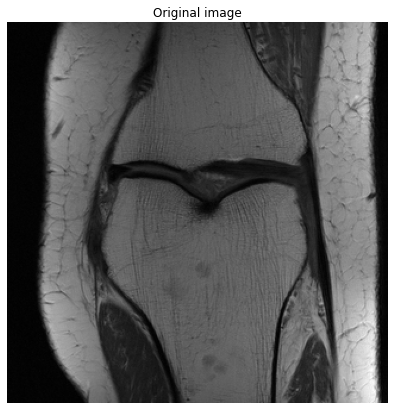

In [15]:
lsimg = lsreconstruction(measurement)
lsrec = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(121)
ax1.imshow(lsrec,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

In [16]:
def channels2imgs(out):
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

In [17]:
# the forward model - treats real and complex part of each slice as a separate channel
def forwardm(img,mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

### Deep decoder setup

In [18]:
num_param(parnet)

3952670

In [19]:
out = []
for img in sampled_image:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [20]:
sover,pover,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                num_channels=[num_channels]*(num_layers-1),
                                                #reg_noise_decayevery = rnd,
                                                #reg_noise_std=rn,
                                                num_iter=numit,
                                                LR=LR,
                                                mask = mask2d,
                                                apply_f = forwardm,
                                                img_noisy_var=unders_measurement,
                                                net=parnet,
                                                upsample_mode="free",
                                                img_clean_var=Variable(lsest).type(dtype),
                                                lsimg = lsimg,
                                                find_best=True,)

input shape:  [1, 256, 10, 5]
optimize with adam 0.005


## Downsampling factor = 12
num_channels: 256 <br>
insize: [10,5] <br> 
num_layers: 7 <br>
iter=25000, lr=0.005

In [21]:
par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

ssim_const = ssim(orig, prec,data_range=orig.max())

psnr_const = psnr(orig,prec,np.max(orig))

real/img parts:  tensor(719.4630, device='cuda:0') tensor(644.8469, device='cuda:0')


In [22]:
psnr_const,ssim_const

(26.63542555203171, 0.6771600617315635)

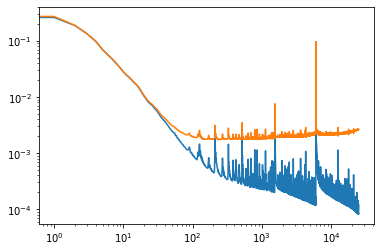

In [23]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

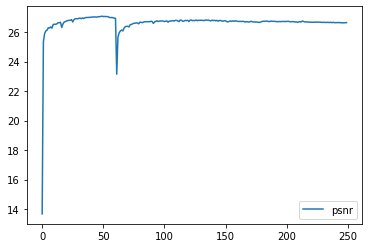

In [24]:
plt.plot(pover,label="psnr")
plt.legend()
plt.show()

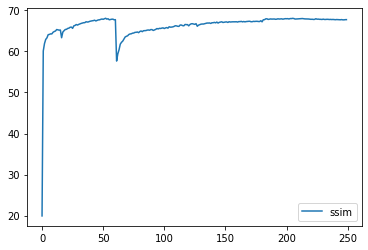

In [25]:
plt.plot(100*np.array(sover),label="ssim")
plt.legend()
plt.show()

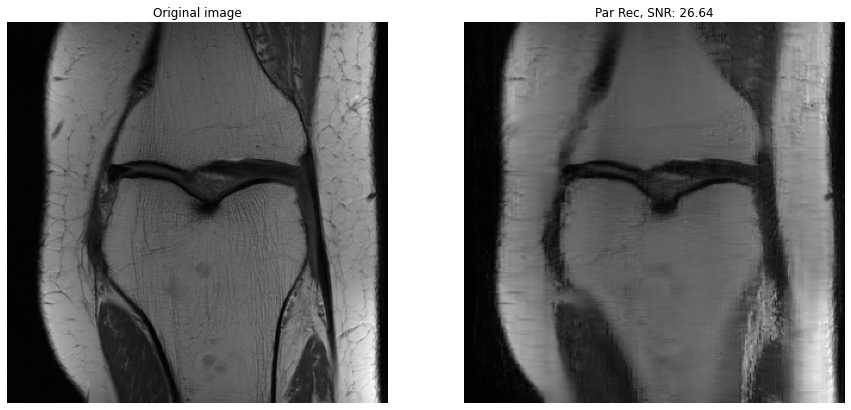

In [26]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

## Downsampling factor = 4
num_channels: 256 <br>
insize: [10,5] <br> 
num_layers: 7 <br>
iter=25000, lr=0.005

In [19]:
par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

ssim_const = ssim(orig, prec,data_range=orig.max())

psnr_const = psnr(orig,prec,np.max(orig))

real/img parts:  tensor(661.3981, device='cuda:1') tensor(592.8040, device='cuda:1')


In [20]:
psnr_const,ssim_const

(32.437570499272596, 0.8196950223371373)

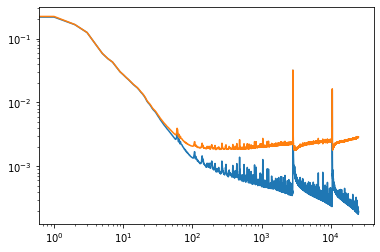

In [21]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

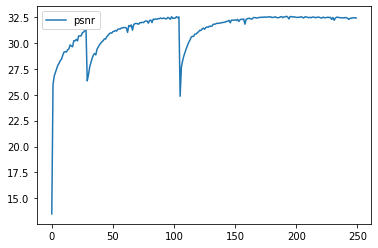

In [22]:
plt.plot(pover,label="psnr")
plt.legend()
plt.show()

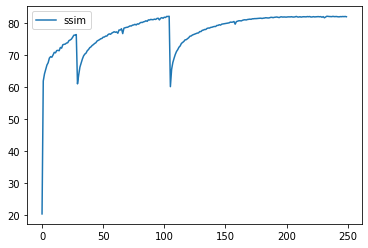

In [23]:
plt.plot(100*np.array(sover),label="ssim")
plt.legend()
plt.show()

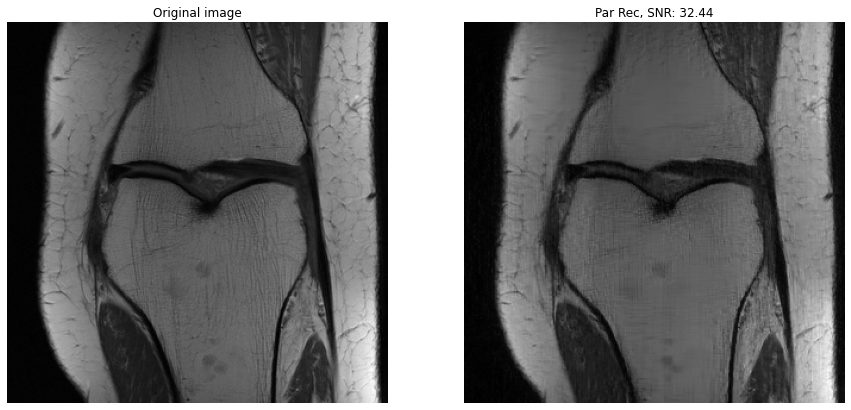

In [24]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

## 512 [10,5] ([30]*3), 7, iter=30000, lr=0.01

In [22]:
psnr_const,ssim_const

(32.05053055496474, 0.8126157789403025)

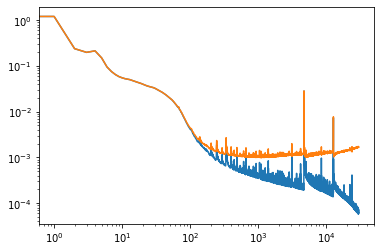

In [23]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

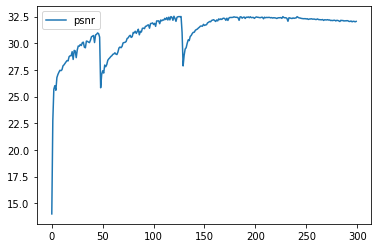

In [24]:
plt.plot(pover,label="psnr")
plt.legend()
plt.show()

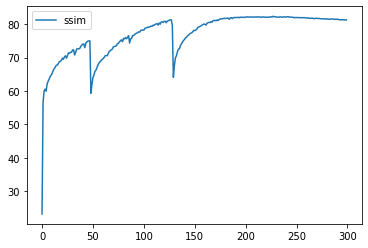

In [25]:
plt.plot(100*np.array(sover),label="ssim")
plt.legend()
plt.show()

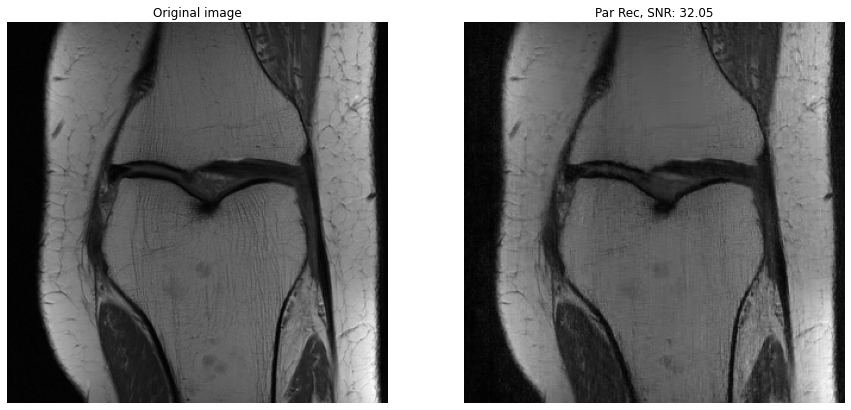

In [26]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

In [25]:
np.array(sover).max()

0.7847515910664737

In [26]:
np.array(pover).max()

31.11353140346873

In [10]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]
num_channelss = [100,120,160,200] # 160
decoders_numlayers_lists = [[4,6,8]] # #layers for each decoding block in the parallel architecture
#num_layers = decoders_numlayers_list[-1]
#decoders_last_channels = [num_channels//2]*3
decoders_last_channelss = [[10]*3,[30]*3]
in_size = [16,16]

rounds = 3

In [11]:
parnet = pardecoder(out_size,in_size,num_output_channels = output_depth,
                 num_channels=num_channelss[0],
                 decoders_numlayers_list = decoders_numlayers_lists[0],
                 decoders_last_channels = decoders_last_channelss[0],
                 need_sigmoid=False,need_pad=False,nonlin_scales=False).type(dtype)
print("#params:",num_param(parnet))
print(parnet)

[[(55, 46), (188, 130), (640, 368)], [(34, 30), (70, 57), (147, 105), (307, 197), (640, 368)], [(28, 26), (46, 40), (78, 62), (132, 96), (224, 151), (378, 236), (640, 368)]]
#params: 156960
cat_model(
  (net1): Sequential(
    (1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Upsample(size=(55, 46), mode=bilinear)
    (3): ReLU()
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): Upsample(size=(188, 130), mode=bilinear)
    (7): ReLU()
    (8): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): Upsample(size=(640, 368), mode=bilinear)
    (11): ReLU()
    (12): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(100, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (net2): Se

In [17]:
numit = 25
rnd = 500
rn = 0.0
LR=[0.01]

In [11]:
mask_filename = '/hdd/multicoil_test_v2/file1001187_v2.h5' #4x mask Test
f_mask = h5py.File(mask_filename, 'r')
mask = np.array(f_mask[list(f_mask.keys())[2]])

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d = mask.copy()
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor*scale_factor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image = transform.ifft2(masked_kspace)

In [ ]:
print("mask shape:", mask.shape)
Psnr = []
Ssim = []
for lr in LR:
    for num_channels in num_channelss:
        for decoders_numlayers_list in decoders_numlayers_lists:
            for decoders_last_channels in decoders_last_channelss:
                num_layers = decoders_numlayers_list[-1]
                PSNR = []
                SSIM = []
                for i in range(rounds):
                    print("round {} begins...".format(i))
                    """
                    mask_func = MaskFunc(center_fractions=[0.07], accelerations=[4])  # Create the mask function object
                    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor*scale_factor, mask_func)   # Apply the mask to k-space
                    mask1d = var_to_np(mask)[0,:,0]
                    undersampling_factor = len(mask1d) / sum(mask1d)
                    tolerance = 0.01
                    while undersampling_factor < 4.0 - tolerance or undersampling_factor > 4.0 + tolerance:
                        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[4])  # Create the mask function object
                        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor*scale_factor, mask_func)   # Apply the mask to k-space
                        mask1d = var_to_np(mask)[0,:,0]
                        undersampling_factor = len(mask1d) / sum(mask1d)
                    mask2d = np.array([mask1d]*640)
                    """
                    
                    print("create parallel decoder...")
                    parnet = pardecoder(out_size,in_size,num_output_channels = output_depth,
                                     num_channels=num_channels,
                                     decoders_numlayers_list = decoders_numlayers_list,
                                     decoders_last_channels = decoders_last_channels,
                                     need_sigmoid=False,need_pad=False,nonlin_scales=False).type(dtype)
                    print("#params:",num_param(parnet))
                    out = []
                    for img in sampled_image:
                        out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
                    lsest = torch.tensor(np.array([out]))

                    sover,pover,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                                num_channels=[num_channels]*(num_layers-1),
                                                                #reg_noise_decayevery = rnd,
                                                                reg_noise_std=rn,
                                                                num_iter=numit,
                                                                LR=lr,
                                                                mask = mask2d,
                                                                apply_f = forwardm,
                                                                img_noisy_var=unders_measurement,
                                                                net=parnet,
                                                                upsample_mode="free",
                                                                img_clean_var=Variable(lsest).type(dtype),
                                                                #lsimg = lsimg,
                                                                find_best=True,)
                    
                    par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
                    par_out_imgs = channels2imgs(par_out_chs)
                    # least squares reconstruciton
                    lsimg = lsreconstruction(measurement)
                    orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

                    # deep decoder reconstruction
                    prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

                    ssim_const = ssim(orig, prec,data_range=orig.max())
                    SSIM.append(ssim_const)

                    psnr_const = psnr(orig,prec,np.max(orig))
                    PSNR.append(psnr_const)
                    
                    #Psnr.append(pover)
                    #Ssim.append(sover)

                    #with open("pover","wb") as fn:
                    #    pickle.dump(Psnr,fn)
                    #with open("sover","wb") as fn:
                    #    pickle.dump(Ssim,fn)

                    #if i == 0:
                    #    with open("./parallel_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
                    #        pickle.dump([par_mse_n,par_mse_t,parni,parnet,measurement], fn)
                    #elif ssim_const > max(SSIM):
                    #    with open("./parallel_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
                    #        pickle.dump([par_mse_n,par_mse_t,parni,parnet,measurement], fn)

                    del(par_mse_n,par_mse_t,parni,parnet)#,precorig,lsimg,lsest)
                    torch.cuda.empty_cache()
                    print("***round {} completed***".format(i),'\n')
                    Psnr.append(("round:{} lr:{} num_channels:{} layer:{} last_channel_contributions:{}".format(i,lr,num_channels,decoders_numlayers_list,decoders_last_channels),psnr_const))
                    Ssim.append(("round:{} lr:{} num_channels:{} layer:{} last_channel_contributions:{}".format(i,lr,num_channels,decoders_numlayers_list,decoders_last_channels),ssim_const))
                    with open("./parallel_psnr_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
                        pickle.dump(Psnr, fn)

                    with open("./parallel_ssim_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
                        pickle.dump(Ssim, fn)
                
                    

mask shape: torch.Size([1, 1, 368, 1])
round 0 begins...
create parallel decoder...
[[(55, 46), (188, 130), (640, 368)], [(34, 30), (70, 57), (147, 105), (307, 197), (640, 368)], [(28, 26), (46, 40), (78, 62), (132, 96), (224, 151), (378, 236), (640, 368)]]
#params: 156960
input shape:  [1, 100, 16, 16]
optimize with adam 0.01
real/img parts:  tensor(418.1077, device='cuda:2') tensor(374.7455, device='cuda:2')52 
***round 0 completed*** 

round 1 begins...
create parallel decoder...
[[(55, 46), (188, 130), (640, 368)], [(34, 30), (70, 57), (147, 105), (307, 197), (640, 368)], [(28, 26), (46, 40), (78, 62), (132, 96), (224, 151), (378, 236), (640, 368)]]
#params: 156960
input shape:  [1, 100, 16, 16]
optimize with adam 0.01
real/img parts:  tensor(418.1077, device='cuda:2') tensor(374.7455, device='cuda:2')51 
***round 1 completed*** 

round 2 begins...
create parallel decoder...
[[(55, 46), (188, 130), (640, 368)], [(34, 30), (70, 57), (147, 105), (307, 197), (640, 368)], [(28, 26), (4

In [13]:
def channels2imgs(out):
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

### Check if scale is right

In [14]:
mask_func = MaskFunc(center_fractions=[0.07], accelerations=[4])  # Create the mask function object
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor*scale_factor, mask_func)   # Apply the mask to k-space
mask1d = var_to_np(mask)[0,:,0]
undersampling_factor = len(mask1d) / sum(mask1d)
tolerance = 0.01
while undersampling_factor < 4.0 - tolerance or undersampling_factor > 4.0 + tolerance:
    mask_func = MaskFunc(center_fractions=[0.07], accelerations=[4])  # Create the mask function object
    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor*scale_factor, mask_func)   # Apply the mask to k-space
    mask1d = var_to_np(mask)[0,:,0]
    undersampling_factor = len(mask1d) / sum(mask1d)
mask2d = np.array([mask1d]*640)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)

In [15]:
parnet = pardecoder(out_size,in_size,num_output_channels = output_depth,
                     num_channels=num_channels,
                     decoders_numlayers_list = decoders_numlayers_list,
                     decoders_last_channels = decoders_last_channels,
                     need_sigmoid=False,need_pad=False,nonlin_scales=True).type(dtype)

[[(108, 82), (640, 368)], [(44, 39), (243, 149), (442, 259), (640, 368)], [(33, 30), (155, 98), (276, 166), (398, 233), (519, 301), (640, 368)]]


In [21]:
# get net input
shape = [1,128,in_size[0],in_size[1]]
print("input shape: ", shape)
ni = Variable(torch.zeros(shape)).type(dtype)
ni.data.uniform_()
#ni.data *= 1./10 # irrelevant

# generate random image
parnet(ni)
out_chs = parnet( ni.type(dtype) ).data.cpu().numpy()[0]
out_imgs = channels2imgs(out_chs)

rec = root_sum_of_squares(out_imgs)

# least squares reconstruciton
orig = root_sum_of_squares(var_to_np(lsreconstruction(unders_measurement))) 

print("those norms should be similar for scale to be right:", np.linalg.norm(orig), np.linalg.norm(rec))

input shape:  [1, 128, 640, 368]
real/img parts:  tensor(485.0675, device='cuda:1') tensor(435.4206, device='cuda:1')
those norms should be similar for scale to be right: 651.8294356805199 661.1347716294613


In [22]:
out_chs.shape

(30, 640, 368)

### Fit deep decoder

In [17]:
out = []
for img in sampled_image:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [18]:
numit = 20000
rnd = 500
rn = 0.0
LR = 0.01

In [20]:
with open("./plain", 'rb') as fn:
    [plain_mse_n,plain_mse_t,plainni,plainnet,measurement_pl] = pickle.load(fn)

In [28]:
unders_measurement.shape,Variable(lsest).shape

(torch.Size([1, 15, 640, 368, 2]), torch.Size([1, 30, 640, 368]))

In [19]:
########################## try a different image when you wake up ########################

In [25]:
torch.cuda.empty_cache()

In [19]:
par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                        num_channels=[num_channels]*(num_layers-1),
                        #reg_noise_decayevery = rnd,
                        reg_noise_std=rn,
                        num_iter=numit,
                        LR=LR,
                        apply_f = forwardm,
                        img_noisy_var=unders_measurement,
                        net=parnet,
                        upsample_mode="free",
                        img_clean_var=Variable(lsest).type(dtype),
                        find_best=True,)

input shape:  [1, 160, 26, 26]
optimize with adam 0.01


In [34]:
with open("./parallel_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
    pickle.dump([par_mse_n,par_mse_t,parni,parnet,measurement], fn)

In [5]:
with open("./parallel", 'rb') as fn:
    [par_mse_n,par_mse_t,parni,parnet,measurement] = pickle.load(fn)

In [20]:
par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)

print(par_out_chs.shape,par_out_imgs.shape)

(30, 640, 372) (15, 640, 372)


In [21]:
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

# normalize
#rec_n = rec / np.linalg.norm(rec)
#orig_n = orig / np.linalg.norm(orig)
prec_n = prec
orig_n = orig

print(np.linalg.norm(prec_n-orig_n) / np.linalg.norm(orig_n) )

ssim_const = ssim(orig_n, prec_n,data_range=orig_n.max())
print("Structural similarity metric:",ssim_const)
print(psnr(orig_n,prec_n,np.max(orig_n)))

real/img parts:  tensor(398.2122, device='cuda:2') tensor(414.5303, device='cuda:2')
0.11994189305814654
Structural similarity metric: 0.6487904474133331
27.488975239456362


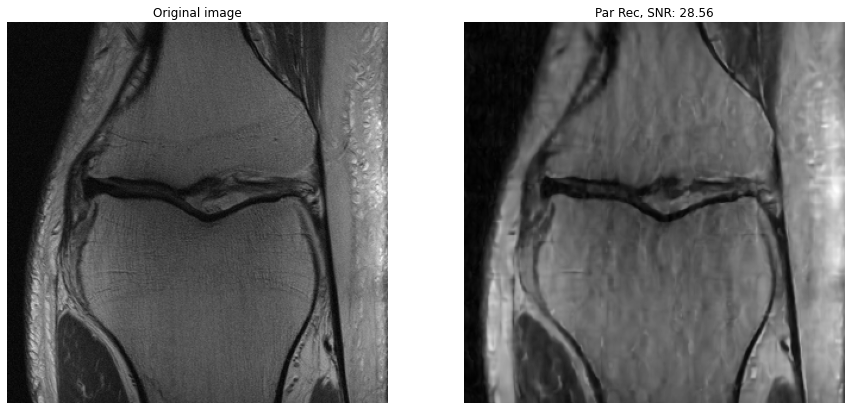

In [22]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig_n,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec_n,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

In [1]:
with open("./parallel_psnr_"+filename.split("/")[-1].split(".")[0], 'rb') as fn:
    dat = pickle.load(fn)
dat.append(psnr(orig_n,prec_n,np.max(orig_n)))
with open("./parallel_psnr_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
    pickle.dump(dat, fn)

NameError: name 'filename' is not defined

In [31]:
with open("./parallel_ssim_"+filename.split("/")[-1].split(".")[0], 'rb') as fn:
    dat = pickle.load(fn)
dat.append(ssim(orig_n, prec_n,data_range=orig_n.max()))
with open("./parallel_ssim_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
    pickle.dump(dat, fn)

In [23]:
with open("./parallel_psnr_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
    pickle.dump([psnr(orig_n,prec_n,np.max(orig_n))], fn)

In [24]:
with open("./parallel_ssim_"+filename.split("/")[-1].split(".")[0], 'wb') as fn:
    pickle.dump([ssim(orig_n, prec_n,data_range=orig_n.max())], fn)

In [25]:
def plot_tensor(out,nrows=8):
    plt.rcParams["figure.figsize"] = (16,16)
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

first decoder


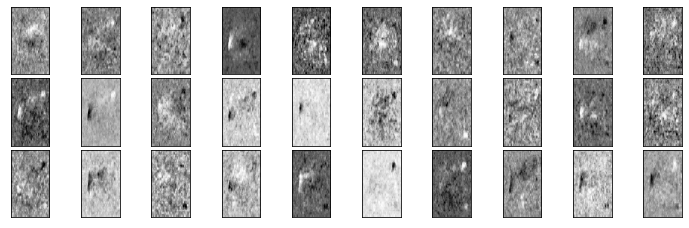

second decoder


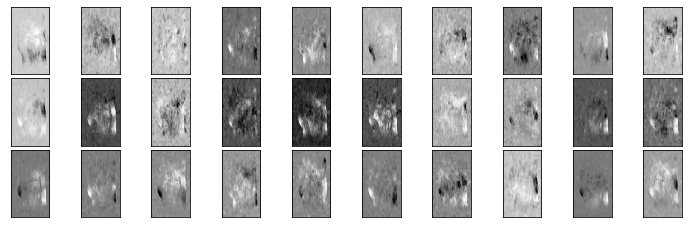

third decoder


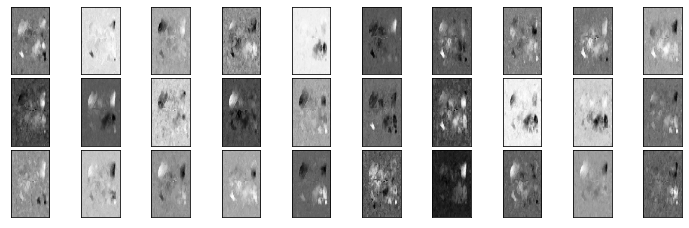

In [26]:
nrows = 3
print("first decoder")
out1 = parnet.net1(parni.type(dtype))
plot_tensor(out1,nrows=nrows)

print("second decoder")
out2 = parnet.net2(parni.type(dtype))
plot_tensor(out2,nrows)

print("third decoder")
out3 = parnet.net3(parni.type(dtype))
plot_tensor(out3,nrows=nrows)

In [27]:
def plot_arbitrary_channels(var,channels,plot_size=(5,5)):
    # var: tensor of shape F*W*H*C (note: W is assumed to be the number of channels)
    # channels: the channels to be plotted
    plt.rcParams["figure.figsize"] = plot_size
    plt.gray()
    #for i in range(var.shape[1]):
    #    if i in channels:
    #        plt.imshow(var[:,i,:,:].detach().cpu()[0])
    #        plt.show()
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)       
    for i in range(1, len(channels)+1):
        ax = fig.add_subplot(1, len(channels), i)
        ax.imshow(var[:,channels[i-1],:,:].detach().cpu()[0])
    plt.show()

<Figure size 432x432 with 0 Axes>

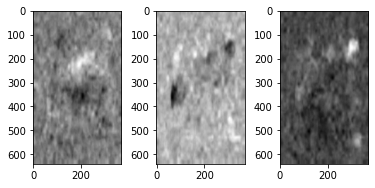

In [28]:
plot_arbitrary_channels(out1,[0,10,20],plot_size=(6,6))

<Figure size 432x432 with 0 Axes>

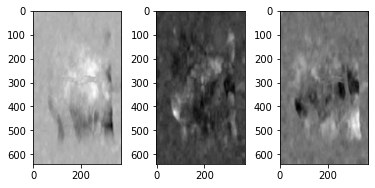

In [29]:
plot_arbitrary_channels(out2,[0,10,20],plot_size=(6,6))

<Figure size 432x432 with 0 Axes>

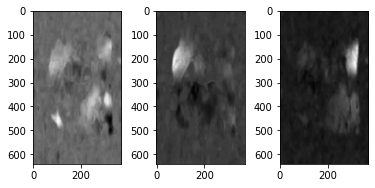

In [30]:
plot_arbitrary_channels(out3,[0,10,20],plot_size=(6,6))

In [41]:
out1[:,1,:,:].detach().cpu()[0].shape

torch.Size([640, 368])

In [24]:
out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(out_chs)

print(out_chs.shape,par_out_imgs.shape)

out_chs = plainnet( plainni.type(dtype)  ).data.cpu().numpy()[0]
plain_out_imgs = channels2imgs(out_chs)

# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

lsimg_pl = lsreconstruction(measurement_pl)
orig_pl = crop_center( root_sum_of_squares(var_to_np(lsimg_pl)) , 320,320)

# deep decoder reconstruction
plainrec = crop_center(root_sum_of_squares(plain_out_imgs),320,320)
parrec = crop_center(root_sum_of_squares(par_out_imgs),320,320)
# normalize
#rec_n = rec / np.linalg.norm(rec)
#orig_n = orig / np.linalg.norm(orig)
plain_rec_n = plainrec
par_rec_n = parrec
orig_n = orig
orig_pl_n = orig_pl

print(np.linalg.norm(plain_rec_n-orig_n) / np.linalg.norm(orig_n) )

print("parallel...")
ssim_const = ssim(orig_n, par_rec_n,data_range=orig_n.max() - orig_n.min())
print(ssim_const)
print(psnr(orig_n,par_rec_n,np.max(orig_n)),'\n')

print("plain...")
ssim_const = ssim(orig_pl_n, plain_rec_n,data_range=orig_pl_n.max() - orig_pl_n.min())
print(ssim_const)
print(psnr(orig_pl_n,plain_rec_n,np.max(orig_pl_n)),'\n')

(30, 640, 368) (15, 640, 368)
real/img parts:  tensor(368.5771, device='cuda:1') tensor(329.6876, device='cuda:1')
real/img parts:  tensor(653.9271, device='cuda:1') tensor(584.9296, device='cuda:1')
0.7728627718638188
parallel...
0.8009073647485645
32.099733184755145 

plain...
0.772911137951218
31.515525591271782 



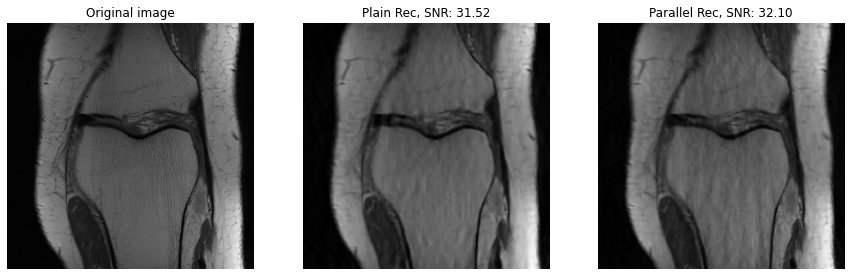

In [25]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(orig_n,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(plain_rec_n,cmap='gray')
ax2.set_title( "Plain Rec, SNR: %.2f" % psnr(orig_pl,plainrec,np.max(orig_pl)) ) 
ax2.axis('off')    

ax3 = fig.add_subplot(133)
ax3.imshow(par_rec_n,cmap='gray')
ax3.set_title( "Parallel Rec, SNR: %.2f" % psnr(orig,parrec,np.max(orig)) ) 
ax3.axis('off')    
    
plt.show()

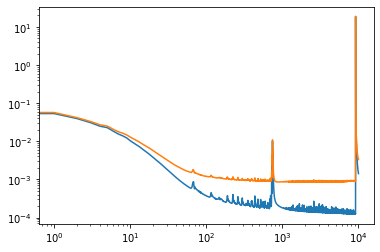

In [161]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

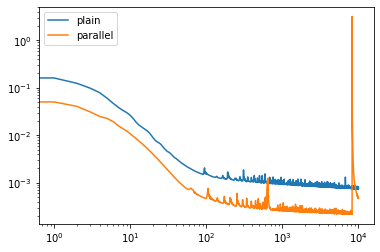

In [26]:
plt.loglog(plain_mse_n,label="plain")
plt.loglog(par_mse_n,label="parallel")
plt.legend()
plt.show()

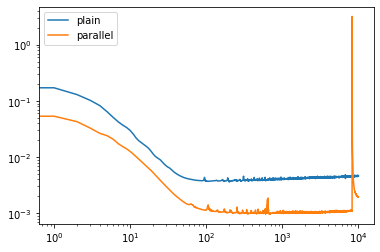

In [27]:
plt.loglog(plain_mse_t,label="plain")
plt.loglog(par_mse_t,label="parallel")
plt.legend()
plt.show()

In [20]:
plain_out_chs = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
plain_out_imgs = channels2imgs(plain_out_chs)

print(plain_out_chs.shape,plain_out_imgs.shape)

NameError: name 'plainni' is not defined

In [76]:
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
plrec = crop_center(root_sum_of_squares(plain_out_imgs),320,320)

# normalize
#rec_n = rec / np.linalg.norm(rec)
#orig_n = orig / np.linalg.norm(orig)
plrec_n = plrec
orig_n = orig

print(np.linalg.norm(plrec_n-orig_n) / np.linalg.norm(orig_n) )

ssim_const = ssim(orig_n, plrec_n,data_range=orig_n.max())
print("Structural similarity metric:",ssim_const)
print(psnr(orig_n,plrec_n,np.max(orig_n)))

real/img parts:  tensor(475.5834, device='cuda:0') tensor(425.4033, device='cuda:0')
0.10535516862630388
Structural similarity metric: 0.7224190020077628
29.1201768232207


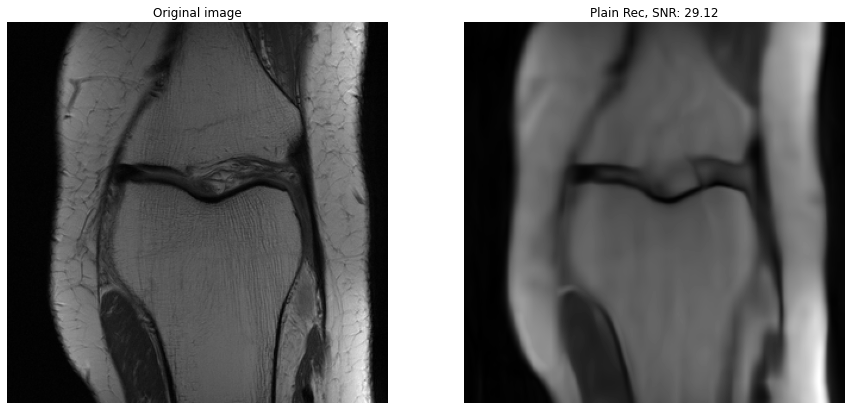

In [77]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig_n,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(plrec_n,cmap='gray')
ax2.set_title( "Plain Rec, SNR: %.2f" % psnr(orig,plrec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

In [28]:
np.linalg.norm(orig),np.linalg.norm(parrec),np.linalg.norm(root_sum_of_squares(par_out_imgs))

(521.5575596457329, 520.6225031850338, 559.8181557447547)

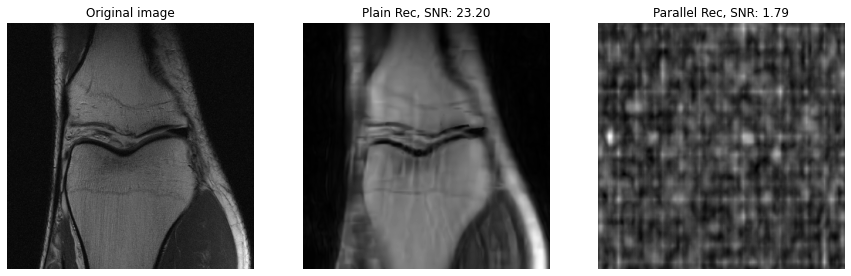

In [146]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(orig_n,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(plain_rec_n,cmap='gray')
ax2.set_title( "Plain Rec, SNR: %.2f" % psnr(orig,plainrec,np.max(plainrec)) ) 
ax2.axis('off')    

ax3 = fig.add_subplot(133)
ax3.imshow(par_rec_n,cmap='gray')
ax3.set_title( "Parallel Rec, SNR: %.2f" % psnr(orig,parrec,np.max(parrec)) ) 
ax3.axis('off')    
    
plt.show()

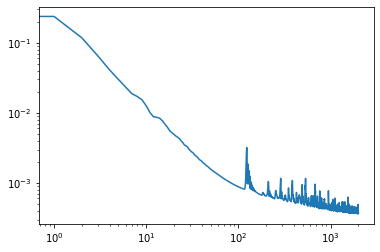

In [52]:
#plt.semilogx(mse_n)
plt.loglog(mse_n)

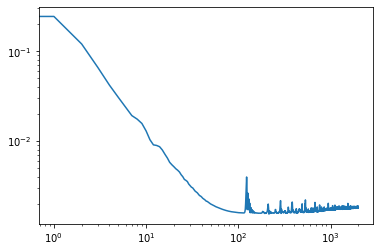

In [53]:
#plt.semilogx(mse_n)
plt.loglog(mse_t)

In [54]:
out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
out_imgs = channels2imgs(out_chs)

print(out_chs.shape,out_imgs.shape)

(30, 640, 368) (15, 640, 368)


rec: 3.558973789215088 5.2859988500131294e-05
orig: 3.658354 6.0271854e-05
rec: 2.789327383041382 1.8316930436412804e-05
orig: 3.149968 0.00019887526
rec: 3.486236095428467 2.108573062287178e-05
orig: 3.5638227 0.00016815416
rec: 0.8247095346450806 1.105753290175926e-05
orig: 1.0093907 0.00013440703
rec: 3.154099941253662 2.535223393351771e-05
orig: 3.5720537 0.00013033733
rec: 5.436028957366943 2.121099896612577e-05
orig: 5.797299 0.00018034033
rec: 5.866495132446289 7.701325557718519e-06
orig: 6.0553226 0.00016180424
rec: 5.5174560546875 1.5453455489478074e-05
orig: 6.606823 5.900501e-05
rec: 1.1808704137802124 1.957703170774039e-05
orig: 1.4392117 0.00021453729
rec: 1.5295642614364624 4.261966023477726e-05
orig: 1.751376 0.00017116826
rec: 9.177031517028809 1.7156458852696232e-05
orig: 10.0 0.00028219205
rec: 7.776765823364258 3.245313564548269e-05
orig: 8.677258 0.00014991025
rec: 7.651504993438721 2.878100349335e-05
orig: 8.967163 9.106493e-05
rec: 9.25001335144043 4.0613460441818

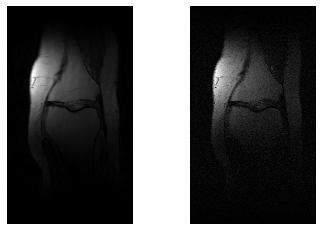

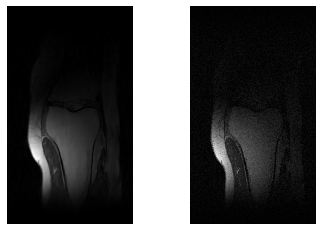

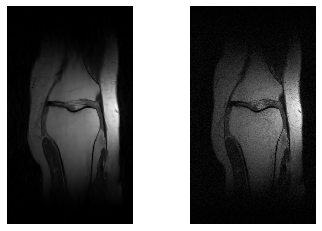

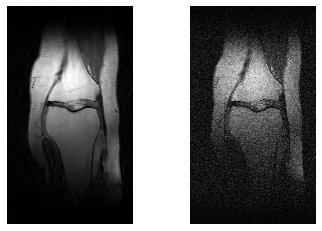

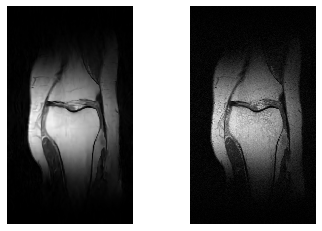

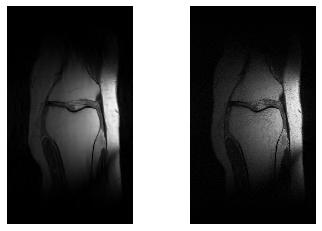

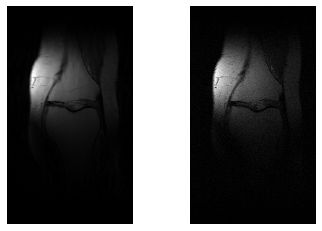

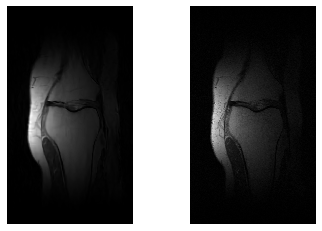

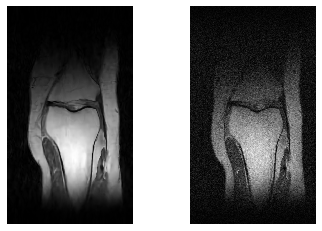

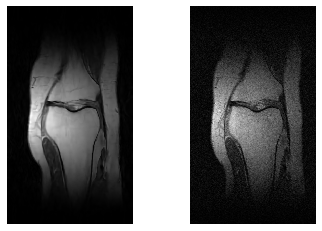

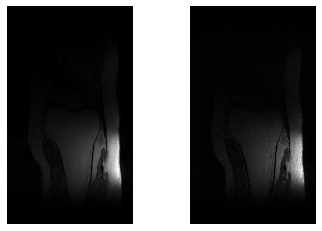

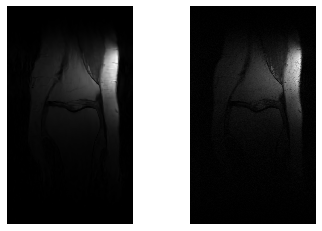

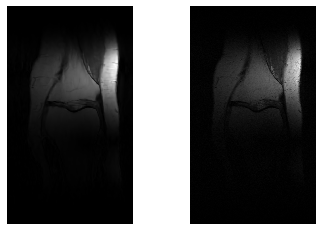

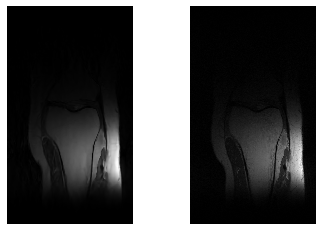

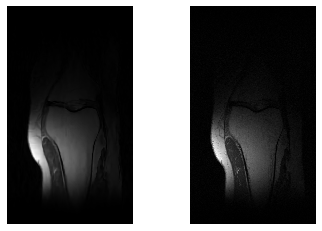

In [20]:
for img,imgorig in zip([img for img in out_imgs],[img for img in var_to_np(lsimg)]):
    print("rec:", np.max(img), np.min(img))
    print("orig:", np.max(imgorig), np.min(imgorig))
    fig = plt.figure() 
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img,cmap='gray')
    ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(imgorig,cmap='gray')
    ax2.axis('off')
    fig.show()

In [55]:
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
rec = crop_center(root_sum_of_squares(out_imgs),320,320)

# normalize
#rec_n = rec / np.linalg.norm(rec)
#orig_n = orig / np.linalg.norm(orig)
rec_n = rec
orig_n = orig

print(np.linalg.norm(rec_n-orig_n) / np.linalg.norm(orig_n) )

ssim_const = ssim(orig_n, rec_n,data_range=orig_n.max())
print("Structural similarity metric:",ssim_const)
print(psnr(orig_n,rec_n,np.max(orig_n)))

real/img parts:  tensor(594.4792, device='cuda:0') tensor(531.7541, device='cuda:0')
0.07864232135225376
Structural similarity metric: 0.7637974619656113
31.660167444098374


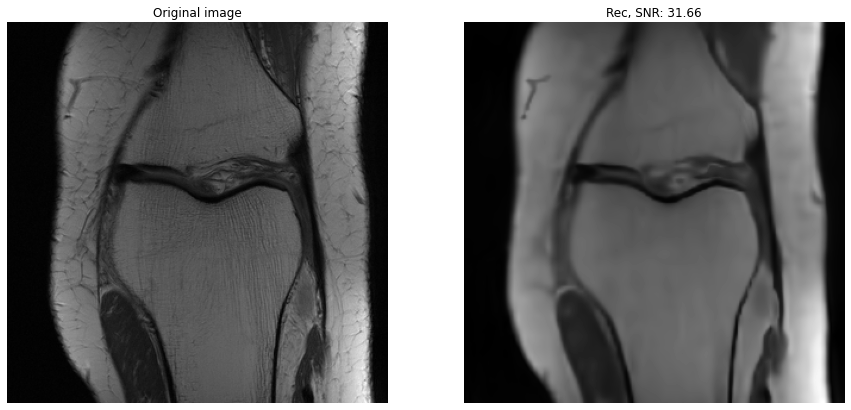

In [56]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig_n,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(rec_n,cmap='gray')
ax2.set_title( "Rec, SNR: %.2f" % psnr(orig,rec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

In [23]:
np.max(orig),np.min(orig)

(14.020029968454727, 0.18965775272063648)

In [24]:
# [256]*5,infactor 10, 10000 iterations, 32.15 db
# [256]*5,infactor 12, 10000 iterations, 31.84 db
# int(out_size[0]/15) , int(out_size[1]/15*1.73) 31.03
# 10000 it [256]*5 15,15: less artificats, SNR: 31.5dB
# 2000 it [256]*5 15,15: less artificats, SNR: 30.91dB -> worse! looks more blurry
# 5000 it [256]*6 15,15: less artificats, SNR: 31.76
# 50,0000 it [256]*6, 15,15: 33.22
# 50,0000 it [512]*6, 15,15: 32.47
# 50,0000 it [256]*6, 15,15: 31.78 but now upsample first
# 50,0000 it [256]*6, 15,15: 32.14 but now upsample first

# Figure 1
# 10,0000 it [256]*6, factor 15,15: 28.60 but now upsample first
# 10,0000 it [256]*6, 16x16: 26.55 but now upsample first
# 10,0000 it [256]*6, 16x16: 26.36 but now upsample first

# 10.000, num_channels = [512]*5 in_size = ( int(out_size[0]/25) , int(out_size[1]/25) )  27.7
# 50.000, num_channels = [512]*5 in_size = ( int(out_size[0]/25) , int(out_size[1]/25) )  25.5



In [25]:
def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=1000)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')

R = np.vstack( (np.array([k for k in range(len(mse_n))]),mse_n,mse_t) ).T
savemtx_for_logplot( R.T, "CS_convergence_MRI.dat")